# Lesson 2 Notes


## Creating a Dataset (Downloading and Cleaning!)

There are many ways to download a large dataset of images by crawling various search engines. I even made my own way in the previous lesson, although it was a bit too complicated. So the best way that I have found to download and clean the dataset is by using a python [package](https://github.com/cwerner/fastclass) created by Christian Werner. Very easy to use and as i think DRY principle is important, I find it useless to do something that has already been done by someone that fullfills my needs. 


In [0]:
!pip install git+https://github.com/cwerner/fastclass.git#egg=fastclass

In [8]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'


Mounted at /content/gdrive


In [0]:
!mv gdrive/My\ Drive/fastai-v3/bears.csv .

In [10]:
!fcd -c GOOGLE -s 224 -m 300 -o data/train bears.csv

INFO: final dataset will be located in data/train
[1/3] Searching: >> black bears <<
(1) Crawling ...
    -> GOOGLE
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 33 bytes but only got 32. Skipping tag 42036
  " Skipping tag %s" % (size, len(data), tag))
Number of duplicate image files: 0. Removing...
(2) Resizing images to (224, 224)
100% 266/266 [00:03<00:00, 88.65it/s]
[2/3] Searching: >> grizzly bears <<
(1) Crawling ...
    -> GOOGLE
Number of duplicate image files: 0. Removing...
(2) Resizing images to (224, 224)
100% 290/290 [00:04<00:00, 60.21it/s]
[3/3] Searching: >> teddy bears <<
(1) Crawling ...
    -> GOOGLE
Number of duplicate image files: 0. Removing...
(2) Resizing images to (224, 224)
100% 288/288 [00:03<00:00, 83.96it/s]


So all I did was use the tool, and download the images that i need by specifying them in a csv file. fcd accepts the queries in a csv file. Easy to create and modify. Also the images are downloaded in their specific folder according to the query that we passed in the .csv file.



*   -c -> Allows us to specify the crawler (GOOGLE, BING)
*   -s -> Resize the image to specified size
*   -m -> The number of images to download per query listed in the .csv file
*   -o -> Specify the output folder where we want to download the images to



In [3]:
!ls data/train && ls data/train/black

ls: cannot access 'data/train': No such file or directory


Next we created a path for our dataset and cleaned it by checking if all the images are verfied not to be corrupt or dirty. 

In [0]:
from fastai.vision import *
from pathlib import Path

In [0]:
classes = ['black', 'grizzly', 'teddy']
path = Path("/content/data/train")

In [13]:
for c in classes:
  print(c)
  verify_images(path/c, delete=True)

black


grizzly


teddy


### Training from the dataset

Now its time to create an ImageDataBunch object. As we haven't created a validation set, we can separated our dataset into validation and training by simply using the *train* and *valid_pct* parameters. Currently we'll set it to 0.2 or 20% of the whole dataset!


In [0]:
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, ds_tfms=get_transforms(), size=224, bs=64, num_workers=4).normalize(imagenet_stats)

In [15]:
data.classes

['black', 'grizzly', 'teddy']

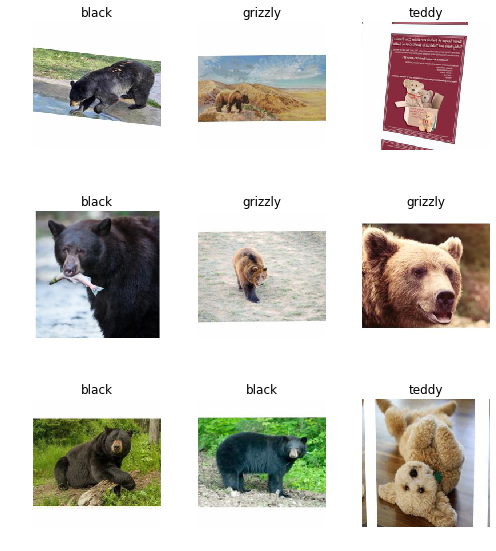

In [16]:
data.show_batch(rows=3, figsize=(7,8))

In [17]:
len(data.valid_ds)

168

In [18]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:04<00:00, 19406883.50it/s]


In [19]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.865272,0.098327,0.023810,00:06
1,0.476262,0.070957,0.023810,00:06
2,0.335715,0.068107,0.023810,00:06
3,0.257896,0.069561,0.023810,00:06


In [0]:
learn.save('stage-1')

In [0]:
learn.unfreeze()

In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


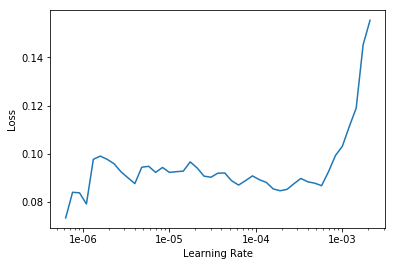

In [23]:
learn.recorder.plot()

We trained the model on our dataset. We then see that yet we have a training loss > validation loss which **shouldn't** be the case. So we save the learner, unfreeze it, find its learning rate and plot a graph. We can see now from here that our learning rate skyrockets between 1e-4 and 1e-3. So what we will do is slice it from there by dividing it by 10!

In [0]:
learn.load('stage-1')

In [0]:
learn.fit_one_cycle(4, max_lr=3e-4)

In [0]:
learn.save("stage-2")

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

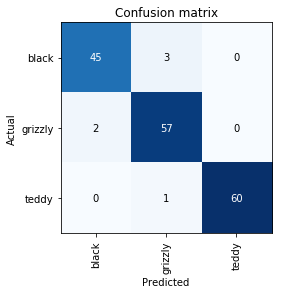

In [36]:
interp.plot_confusion_matrix()

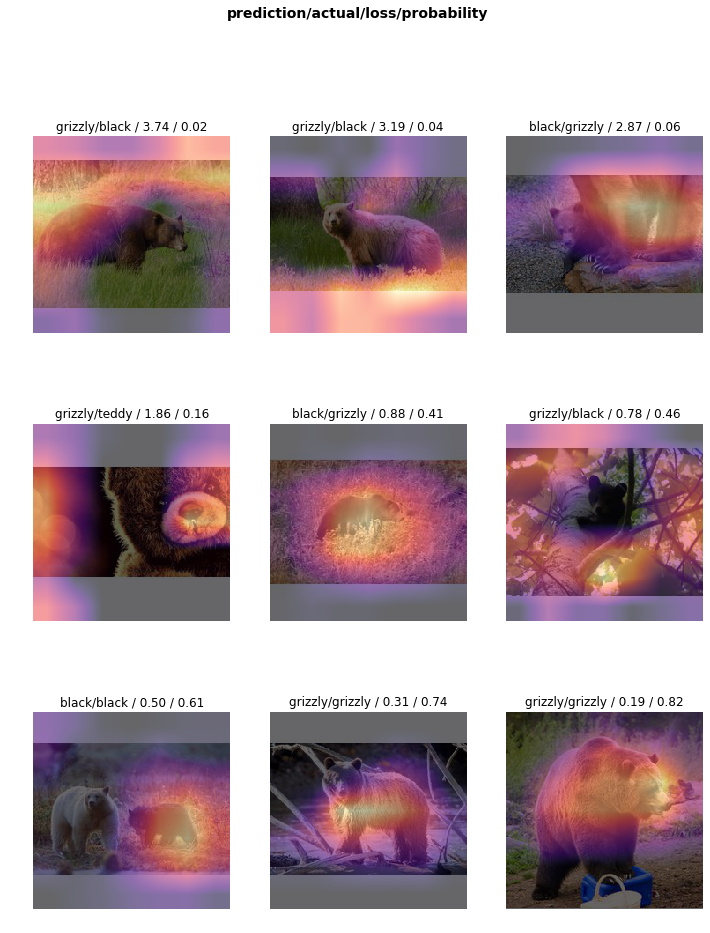

In [38]:
interp.plot_top_losses(9, figsize=(12,15))

As we can infer from above, the learner is not having any problems and our classifier is working quite well. A few mistakes are that the images in our dataset are incorrect, which can be removed easily by using their indexes.

### Deploying our model

We can very easily export our model and then deploy it wherever we like. The exported model can predict using a CPU as well. It needs a GPU only if there is training going while prediction as well. So running predictions on a CPU is not an issue!

In [0]:
learn.export("model.pkl")

In [47]:
!cd data/train/ && ls

black	   export.pkl  grizzly.log  models  teddy.log
black.log  grizzly     model.pkl    teddy


To load a learner we simply use the load_learner which returns the model.

In [0]:
learn = load_learner(path,"model.pkl")

A few things to remember are :-
1. Learning rate is the rate at which your model trains itself. By default its 3e-03 = 0.003.
2. Epochs is the number of times the batchsize completes training itself on the whole dataset.
3. Too small/big learning rate can be a problem. A sweet spot needs to be found out. Mostly it isnt the learning rate that is creating the problems rather our dataset is dirty!
4. Too few/lots of epoch can make our model predictions worthless. Always according to need the epochs should be decided.

## Stochastic Gradient Descent

Stochastic Gradient Descent is an optimization technique used for neural nets. Optimizing means finding the best fit among all for a given data and its model. 

In [0]:
%matplotlib inline
from fastai.basics import *

We will now create a dataset with 100 points. We will be randomly creating data points using pytorch's functions. The 2nd column of the dataset for a linear line will always be a 1.

In [57]:
n=100
x=torch.ones(n,2)
x[:,0].uniform_(-1,1)
x[:5]

tensor([[-0.9986,  1.0000],
        [-0.4912,  1.0000],
        [-0.6078,  1.0000],
        [ 0.4886,  1.0000],
        [ 0.8906,  1.0000]])

In [59]:
a = tensor(3.,2)
a

tensor([3., 2.])

A tensor is just a mathematical concept just like a vector. A tensor can have dimensions. A tensor with 1 dimension is normally called a vector, 2 dimensions a matrix and so on.

In [0]:
y = x@a + torch.rand(n)

Now we create a function for y which says that for every value of x multiply it by a. We just add a random number in it, like a constant. What **@** does is it multiplies the matrix **x** by the vector tensor **a**

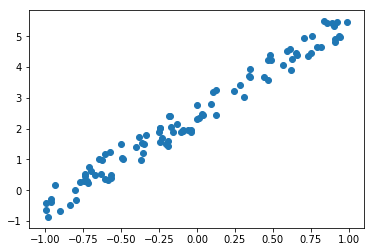

In [63]:
plt.scatter(x[:,0], y)

This is the final dataset that we created! Now lets forget all the data that we used earlier like the **a** vector tensor. We have to fit a line to the data that we now have using optimization techniques. We can do that by a **mean squared error** or mse function. It will be our loss function. We want the minimum loss and the parameters that fit it will be the best fitting line.

In [0]:
def mse(y_hat, y): return ((y_hat-y)**2).mean()

Now lets start building our optimization function that will return us the best value of **a** vector that will have the **minimum** loss value for all the data points. Before that we need some starting point. So lets start with -1,1

In [0]:
a = tensor(-1.,1)

In [0]:
a = nn.Parameter(a)

* y_hat -> the current data point that we predict.
* y -> the actual data point
* mse -> mean squared error func
* lr -> The learning rate that we want to use. Too large and it will have more loss, Too less and it will learn slowly!

Here we are taking the derivative at each step to find out the minimal loss and then subtracting it from the original vector a.

In [0]:
def update():
  y_hat = x@a
  loss = mse(y_hat, y)
  if t % 10 == 0: print(loss)
  loss.backward()
  with torch.no_grad():
    a.sub_(lr * a.grad)
    a.grad.zero_()

Now we'll set a learning rate and we'll update the loss and a vector for every data point!

In [69]:
lr = 1e-1
for t in range(100): update()

tensor(7.1946, grad_fn=<MeanBackward0>)
tensor(1.4883, grad_fn=<MeanBackward0>)
tensor(0.4194, grad_fn=<MeanBackward0>)
tensor(0.1667, grad_fn=<MeanBackward0>)
tensor(0.1062, grad_fn=<MeanBackward0>)
tensor(0.0918, grad_fn=<MeanBackward0>)
tensor(0.0883, grad_fn=<MeanBackward0>)
tensor(0.0875, grad_fn=<MeanBackward0>)
tensor(0.0873, grad_fn=<MeanBackward0>)
tensor(0.0872, grad_fn=<MeanBackward0>)


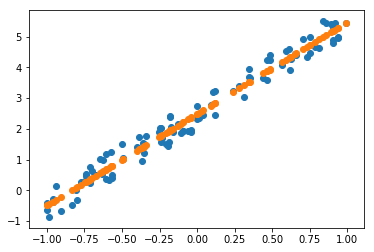

In [70]:
plt.scatter(x[:,0], y)
plt.scatter(x[:,0], x@a)